## Imports and definitions

In [2]:
import ot
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ot
from utils.image import Image
from utils.Visualizations import *
from utils.utils import *
import itertools
import glob
from scipy.stats import normaltest, gaussian_kde, probplot
import time
from tqdm import tqdm

In [3]:
dotmark_pictures_path = "..\\DOTmark_1.0\\Pictures\\"
full_path = os.path.join(os.getcwd(), dotmark_pictures_path)

In [8]:
resolutions = [32, 64, 128, 256, 512]
resolution = 32
image_numbers = ['01','02','03','04','05','06','07','08','09','10']

In [5]:
categories_pattern = os.path.join(dotmark_pictures_path, "*")
category_dirs = [path for path in glob.glob(categories_pattern) if os.path.isdir(path)]
category_names = [os.path.basename(category) for category in category_dirs if os.path.isdir(category)]
for category in category_names:
    print(category)

CauchyDensity
ClassicImages
GRFmoderate
GRFrough
GRFsmooth
LogGRF
LogitGRF
MicroscopyImages
Shapes
WhiteNoise


# Reading images

## Single Image

In [141]:
image_1_index = 2
image_2_index = 3
resolution = 32
noise_param = 5e-2
SNR = 1

In [142]:
len(category_names)
category_names[0]

'CauchyDensity'

In [143]:
len(image_numbers)


10

In [144]:
image1 = Image(resolution, category_names[0], image_1_index, full_path)
image2 = Image(resolution, category_names[0], image_2_index, full_path)
cost_matrix = calculate_costs(image1.image.shape)


In [145]:
results = Image.analyze_image_pair(image1, image2, cost_matrix, 1, noise_param)

In [146]:
print(f'The mass of image1 noised before norm is {image1.image_noised.sum()}')
print(f'The mass of image1 post before norm is {image1.image_post_noised.sum()}')
print(f'The mass of image2 noised before norm is {image2.image_noised.sum()}')
print(f'The mass of image2 post before norm is {image2.image_post_noised.sum()}')

The mass of image1 noised before norm is 1.6942956691598359
The mass of image1 post before norm is 41.0927303017583
The mass of image2 noised before norm is 0.6602254263103611
The mass of image2 post before norm is 40.05866005890883


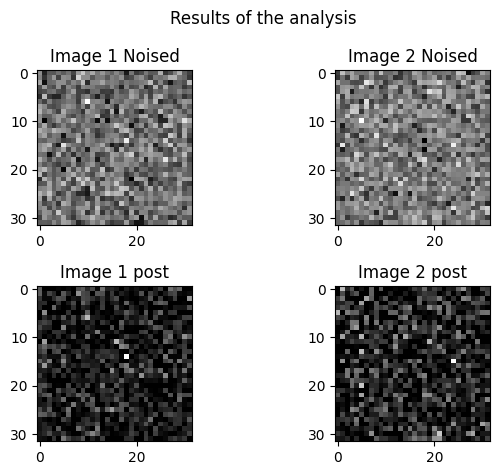

In [147]:
# Plot using 4 plots
fig, axs = plt.subplots(2, 2)
fig.suptitle('Results of the analysis')
axs[0, 0].imshow(image1.image_noised, cmap='gray')
axs[0, 0].set_title('Image 1 Noised')
axs[0, 1].imshow(image2.image_noised, cmap='gray')
axs[0, 1].set_title('Image 2 Noised')
axs[1, 0].imshow(image1.image_post_noised, cmap='gray')
axs[1, 0].set_title('Image 1 post')
axs[1, 1].imshow(image2.image_post_noised, cmap='gray')
axs[1, 1].set_title('Image 2 post')

plt.tight_layout()
plt.show()

In [148]:
alpha_1 = (1 / image1.image_post_noised.sum()) - 1
alpha_2 = (1 / image2.image_post_noised.sum()) - 1

In [149]:
image_indexes = np.random.randint(0, 10, 2)
category_indexes = np.random.randint(0, 10, 2)
# category_indexes = [0, 0]
image1 = Image(resolution, category_names[category_indexes[0]], 
               image_numbers[image_indexes[0]], full_path)
image2 = Image(resolution, category_names[category_indexes[1]], 
               image_numbers[image_indexes[1]], full_path)

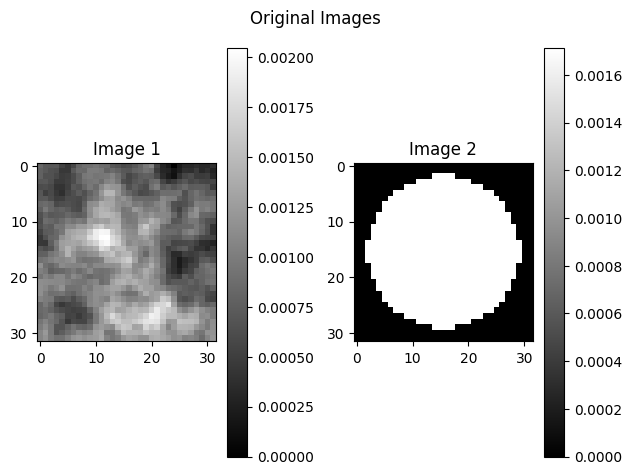

In [150]:
# Show the images:
fig, axs = plt.subplots(1, 2)
fig.suptitle('Original Images')
axs[0].imshow(image1.image, cmap='gray')
axs[0].set_title('Image 1')
fig.colorbar(axs[0].imshow(image1.image, cmap='gray'), ax=axs[0])
axs[1].imshow(image2.image, cmap='gray')
axs[1].set_title('Image 2')
fig.colorbar(axs[1].imshow(image2.image, cmap='gray'), ax=axs[1])
plt.tight_layout()
plt.show()

In [151]:
num_exp = 10000
B_x_matrices = np.zeros((num_exp, resolution, resolution))
B_x_matrices_sub = np.zeros((num_exp, resolution, resolution))
B_x_matrices_sup = np.zeros((num_exp, resolution, resolution))
alpha_1s = np.zeros(num_exp)
alpha_2s = np.zeros(num_exp)

for i in tqdm(range(num_exp)):
    results = Image.process_images(image1, image2, noise_param)

    alpha_1 = (1 / image1.image_post_noised.sum()) - 1
    alpha_2 = (1 / image2.image_post_noised.sum()) - 1

    B_x = image1.image_post_noised * alpha_1 - image2.image_post_noised * alpha_2

    alpha_1s[i] = alpha_1
    alpha_2s[i] = alpha_2
    B_x_matrices[i, :, :] = B_x
    B_x_matrices_sub[i, :, :] = image1.image * alpha_1 - image2.image * alpha_2 - B_x

B_x_mean = np.mean(B_x_matrices, axis=0)
B_x_std = np.std(B_x_matrices, axis=0)
B_x_mean_sub = np.mean(B_x_matrices_sub, axis=0)
B_x_std_sub = np.std(B_x_matrices_sub, axis=0)


100%|██████████| 10000/10000 [00:01<00:00, 8480.21it/s]


In [152]:
B_x_mean_sub.shape

(32, 32)

#### $\alpha_p$

In [153]:
print(f'The original std is {noise_param}')
print(f'The mean of alpha_1 is {np.mean(alpha_1s)} and the std is {np.std(alpha_1s)}')
print(f'The mean of alpha_2 is {np.mean(alpha_2s)} and the std is {np.std(alpha_2s)}')
alpha_sub = alpha_1s - alpha_2s
print(f'The mean of alpha_sub is {np.mean(alpha_sub)} and the std is {np.std(alpha_sub)}')

The original std is 0.05
The mean of alpha_1 is -0.9755073143016456 and the std is 0.000800069458845797
The mean of alpha_2 is -0.9754965020715813 and the std is 0.0008066247966738756
The mean of alpha_sub is -1.0812230064317285e-05 and the std is 0.001379941708043452


Alpha 1 normality test: 28.12559634559098, 7.809160581884262e-07
Alpha 2 normality test: 42.364304662698366, 6.31986974887567e-10


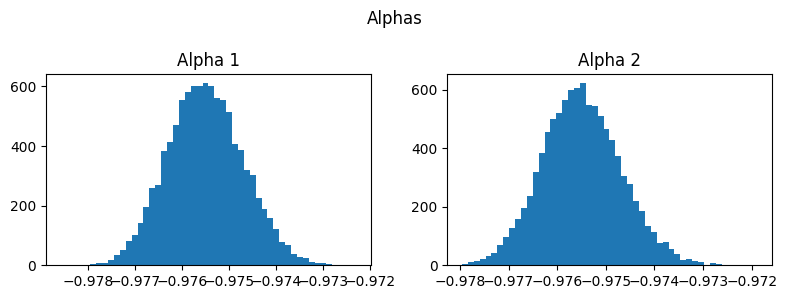

In [158]:
# Plot the alphas
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
fig.suptitle('Alphas')
axs[0].hist(alpha_1s, bins=50)
axs[0].set_title('Alpha 1')
# Normality test for alpha 1
stat, p = normaltest(alpha_1s)
print(f'Alpha 1 normality test: {stat}, {p}')
axs[1].hist(alpha_2s, bins=50)
axs[1].set_title('Alpha 2')
# Normality test for alpha 2
stat, p = normaltest(alpha_2s)
print(f'Alpha 2 normality test: {stat}, {p}')
plt.tight_layout()
plt.show()

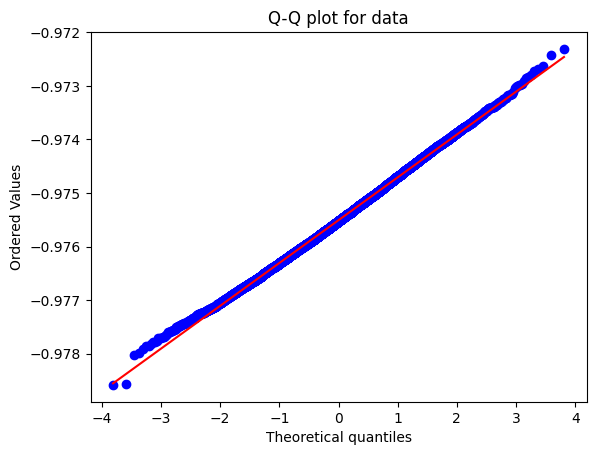

In [155]:
probplot(alpha_1s, dist="norm", plot=plt)
plt.title('Q-Q plot for data')
plt.show()

#### B_x

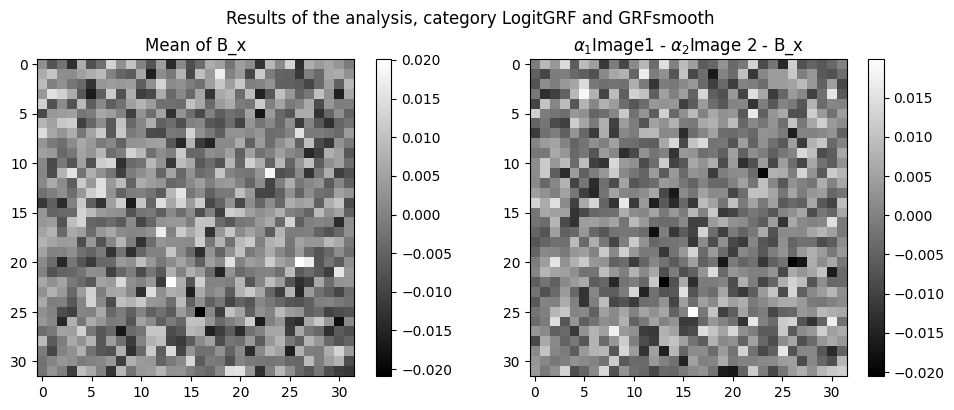

In [120]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle(f'Results of the analysis, category {category_names[category_indexes[0]]} and {category_names[category_indexes[1]]}')
axs[0].imshow(B_x_mean, cmap='gray')
axs[0].set_title('Mean of B_x')
fig.colorbar(axs[0].imshow(B_x_mean, cmap='gray'), ax=axs[0])
axs[1].imshow(B_x_mean_sub, cmap='gray')
axs[1].set_title(r'$\alpha_1$Image1 - $\alpha_2$Image 2 - B_x')
fig.colorbar(axs[1].imshow(B_x_mean_sub, cmap='gray'), ax=axs[1])
plt.tight_layout()
plt.show()

Original std is 0.5
Mean: -0.0001505285407072871, Std: 0.006809747327925615
D'Agostino and Pearson's Test: Stat=1.1240382026418447, P-value=0.5700568984342562


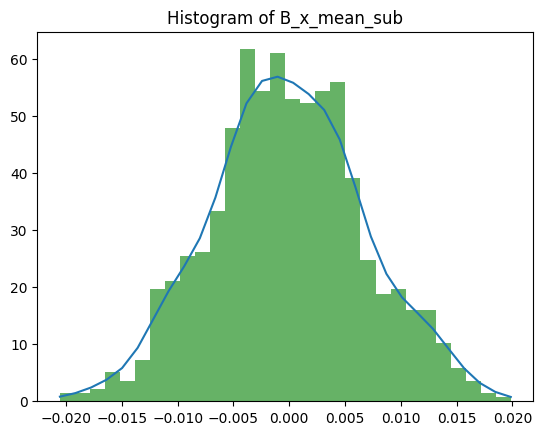

In [121]:
print(f'Original std is {noise_param}')
plt.hist(B_x_mean_sub.flatten(), bins=30, density=True, alpha=0.6, color='g')
print(f"Mean: {np.mean(B_x_mean_sub.flatten())}, Std: {np.std(B_x_mean_sub.flatten())}")
stat, p_value = normaltest(B_x_mean_sub.flatten())
print(f"D'Agostino and Pearson's Test: Stat={stat}, P-value={p_value}")
kde = gaussian_kde(B_x_mean_sub.flatten(), bw_method='silverman')
x = np.linspace(B_x_mean_sub.min(), B_x_mean_sub.max(), 30)
kde_pdf = kde(x)
plt.plot(x, kde_pdf, label='KDE')
plt.title('Histogram of B_x_mean_sub')
plt.show()

#### B_x at random point

In [110]:
B_x_matrices.shape

(10000, 32, 32)

In [112]:
location = np.random.randint(0, resolution, 2)
pixel_values = B_x_matrices_sub[:, location[0], location[1]]

In [113]:
mean_value = np.mean(pixel_values)
std_dev = np.std(pixel_values)
min_value = np.min(pixel_values)
max_value = np.max(pixel_values)

print(f"Mean: {mean_value}, Standard Deviation: {std_dev}, Min: {min_value}, Max: {max_value}")

Mean: -0.0036354253628495675, Standard Deviation: 0.7072170499937973, Min: -2.9102987570308536, Max: 2.6932504468844254


Mean: -0.0036354253628495675, Standard Deviation: 0.7072170499937973


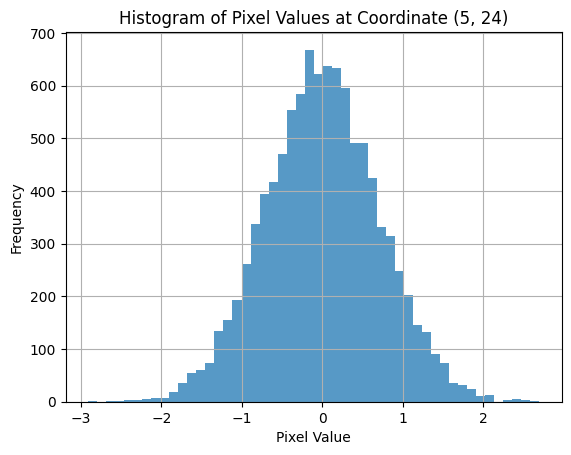

In [114]:
plt.hist(pixel_values, bins=50, alpha=0.75)
print(f"Mean: {mean_value}, Standard Deviation: {std_dev}")
plt.title(f'Histogram of Pixel Values at Coordinate ({location[0]}, {location[1]})')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [77]:
from scipy.stats import shapiro, normaltest

# Shapiro-Wilk Test
stat, p_value = shapiro(pixel_values)
print(f"Shapiro-Wilk Test: Stat={stat}, P-value={p_value}")

# D'Agostino and Pearson's Test
stat, p_value = normaltest(pixel_values)
print(f"D'Agostino and Pearson's Test: Stat={stat}, P-value={p_value}")

Shapiro-Wilk Test: Stat=0.9998536109924316, P-value=0.8014979958534241
D'Agostino and Pearson's Test: Stat=1.0309621236464126, P-value=0.5972132290186749


c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### This is for a single $B_x$

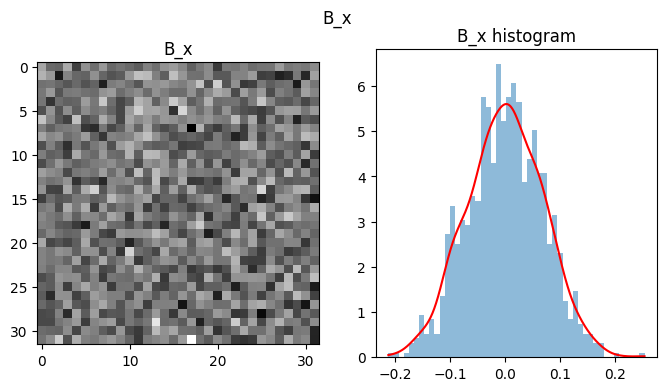

In [67]:
from scipy.stats import norm, gaussian_kde
# Show B_x and it's histogram:
figsize = (8, 4)
fig, axs = plt.subplots(1, 2, figsize=figsize)
fig.suptitle('B_x')
axs[0].imshow(B_x, cmap='gray')
axs[0].set_title('B_x')

axs[1].hist(B_x.flatten(), bins=50, density=True, alpha=0.5, label='Histogram')
kde = gaussian_kde(B_x.flatten(), bw_method='silverman')
x = np.linspace(B_x.min(), B_x.max(), 1000)
kde_pdf = kde(x)
axs[1].plot(x, kde_pdf, label='KDE', color='red')
axs[1].set_title('B_x histogram')

plt.show()

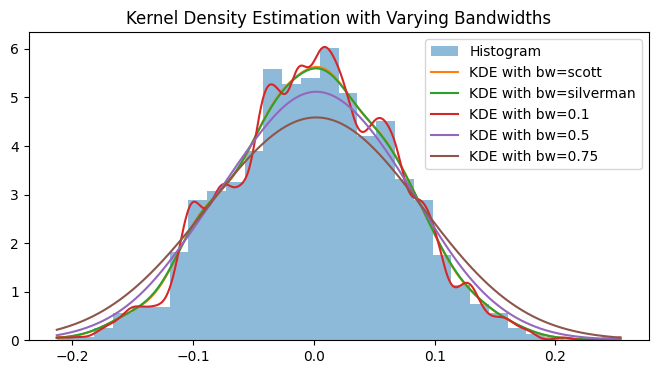

In [68]:
def plot_kde(data, bandwidths):
    fig, ax = plt.subplots(figsize=(8, 4))
    # Histogram
    ax.hist(data, bins=30, density=True, alpha=0.5, label='Histogram')

    # Generate x values for plotting
    x = np.linspace(min(data), max(data), 1000)

    # Plot KDE for each specified bandwidth
    for bw in bandwidths:
        kde = gaussian_kde(data, bw_method=bw)
        kde_pdf = kde(x)
        ax.plot(x, kde_pdf, label=f'KDE with bw={bw}')
    
    ax.set_title('Kernel Density Estimation with Varying Bandwidths')
    ax.legend()
    plt.show()

# List of bandwidths to try
bandwidths = ['scott', 'silverman', 0.1, 0.5, 0.75]

# Plotting the KDE with different bandwidths
plot_kde(B_x.flatten(), bandwidths)

In [69]:
print(f'For noise level {noise_param}, The mean of B_x is {B_x.mean()} and the std is {B_x.std()}')

For noise level 0.05, The mean of B_x is 0.00010844656001545686 and the std is 0.06885408947839884


#### Going over all B_x's, we would look into the means:

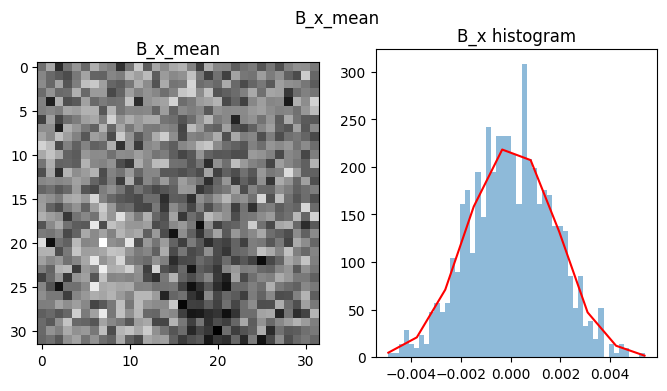

In [71]:
from scipy.stats import norm, gaussian_kde
# Show B_x and it's histogram:
figsize = (8, 4)
fig, axs = plt.subplots(1, 2, figsize=figsize)
fig.suptitle('B_x_mean')
axs[0].imshow(B_x_mean, cmap='gray')
axs[0].set_title('B_x_mean')

axs[1].hist(B_x_mean.flatten(), bins=50, density=True, alpha=0.5, label='Histogram')
kde = gaussian_kde(B_x_mean.flatten(), bw_method='silverman')
x = np.linspace(B_x_mean.min(), B_x_mean.max(), 10)
kde_pdf = kde(x)
axs[1].plot(x, kde_pdf, label='KDE', color='red')
axs[1].set_title('B_x histogram')

plt.show()

In [73]:
print(f'For noise level {noise_param}, The mean of B_x is {B_x_mean.mean()} and the std is {B_x_std.std()}')

For noise level 0.05, The mean of B_x is 2.559827016553523e-05 and the std is 0.0010905769320819234


In [16]:
noise_values = np.logspace(start = -8, stop = 2, num = 100)
# noise_values = np.logspace(start = -3, stop = -1, num = 6)

In [75]:
image_indexes = np.random.randint(1, 10, 2)
image_indexes[1]

4

In [62]:
num_exp = 1000
alpha_1s = np.zeros(num_exp)
alpha_2s = np.zeros(num_exp)
B_x_means = np.zeros(len(noise_values))
B_x_stds = np.zeros(len(noise_values))
alpha_means = np.zeros(len(noise_values))
alpha_stds = np.zeros(len(noise_values))

for noise in tqdm(noise_values):
    noise_location = np.where(noise_values == noise)
    temp_stds = []
    temp_means = []
    temp_alpha = []
    image_indexes = np.random.randint(0, 10, 2)
    category_indexes = np.random.randint(0, 10, 2)
    image1 = Image(resolution, category_names[category_indexes[0]], image_numbers[image_indexes[0]], full_path)
    image2 = Image(resolution, category_names[category_indexes[1]], image_numbers[image_indexes[1]], full_path)

    for i in range(num_exp):
        #image1 = Image(resolution, category_names[0], image_1_index, full_path)
        #image2 = Image(resolution, category_names[0], image_2_index, full_path)
        results = Image.process_images(image1, image2, noise)

        alpha_1 = (1 / image1.image_post_noised.sum()) - 1
        alpha_2 = (1 / image2.image_post_noised.sum()) - 1

        B_x = image1.image_post_noised * alpha_1 - image2.image_post_noised * alpha_2

        alpha_1s[i] = alpha_1
        alpha_2s[i] = alpha_2

        temp_means.append(B_x.mean())
        temp_stds.append(B_x.std()) 
        temp_alpha.append(alpha_1)

    B_x_means[noise_location] = np.array(temp_means).mean()
    B_x_stds[noise_location] = np.array(temp_stds).mean()
    alpha_means[noise_location] = np.array(temp_alpha).mean()
    alpha_stds[noise_location] = np.array(temp_alpha).std()

100%|██████████| 100/100 [00:12<00:00,  7.83it/s]


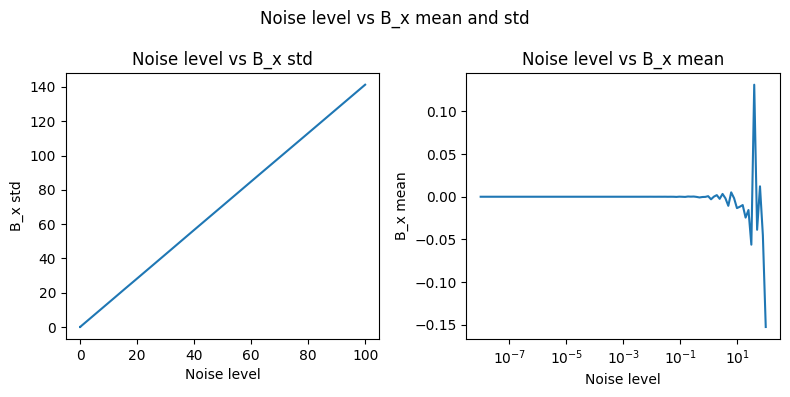

In [63]:
# Plot The noise vs the std of B_x and the mean on the other side
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Noise level vs B_x mean and std')
axs[0].plot(noise_values, B_x_stds)
axs[0].set_xlabel('Noise level')
# axs[0].set_xscale('log')
axs[0].set_ylabel('B_x std')
axs[0].set_title('Noise level vs B_x std')
axs[1].plot(noise_values, B_x_means)
axs[1].set_xlabel('Noise level')
axs[1].set_xscale('log')
axs[1].set_ylabel('B_x mean')
axs[1].set_title('Noise level vs B_x mean')

plt.tight_layout()
plt.show()

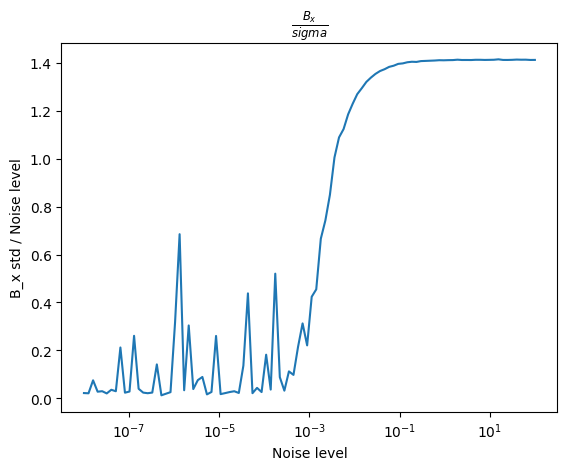

In [64]:
plt.plot(noise_values, B_x_stds / noise_values)
plt.xlabel('Noise level')
plt.xscale('log')
plt.ylabel('B_x std / Noise level')
plt.title(r"$\frac{B_x}{sigma}$")
plt.show()

In [65]:
print(f'The left asimptote of the graph is {B_x_stds[0] / noise_values[0]}')
print(f'The right asimptote of the graph is {B_x_stds[-1] / noise_values[-1]}')

The left asimptote of the graph is 0.021691559730611848
The right asimptote of the graph is 1.4128203085883695


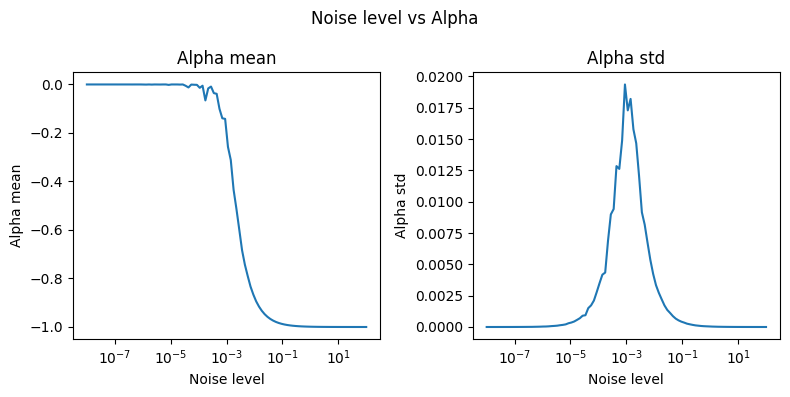

In [66]:
# plot alpha as a function of noise
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Noise level vs Alpha')
axs[0].plot(noise_values, alpha_means)
axs[0].set_xlabel('Noise level')
axs[0].set_xscale('log')
axs[0].set_ylabel('Alpha mean')
axs[0].set_title('Alpha mean')
axs[1].plot(noise_values, alpha_stds)
axs[1].set_xlabel('Noise level')
axs[1].set_xscale('log')
axs[1].set_ylabel('Alpha std')
axs[1].set_title('Alpha std')

plt.tight_layout()
plt.show()

#### New experiment - Looking into the differences inside each pixel on different experiments.

In [44]:
num_exp = 1000
B_x_distribution = pd.DataFrame(columns=['Noise', 'B_Mean', 'B_Std', 'B_tilde_Mean', 'B_tilde_Std', 'Alpha1_Mean', 
                                         'Alpha1_Std', 'Alpha2_Mean', 'Alpha2_Std'])
B_x_matrices = np.zeros((num_exp, resolution, resolution))
B_x_tilde_matrices = np.zeros((num_exp, resolution, resolution))
# noise_values = np.logspace(start = -3, stop = -1, num = 6)

for noise in tqdm(noise_values):
    image_indexes = np.random.randint(0, 10, 2)
    category_indexes = np.random.randint(0, 10, 2)
    alpha_1s = np.zeros(num_exp)
    alpha_2s = np.zeros(num_exp)
    alpha_subs = np.zeros(num_exp)
    image1 = Image(resolution, category_names[category_indexes[0]], image_numbers[image_indexes[0]], full_path)
    image2 = Image(resolution, category_names[category_indexes[1]], image_numbers[image_indexes[1]], full_path)

    B_xs = np.zeros((num_exp, resolution, resolution))
    
    for i in range(num_exp):
        results = Image.process_images(image1, image2, noise)

        alpha_1 = (1 / image1.image_post_noised.sum()) - 1
        alpha_2 = (1 / image2.image_post_noised.sum()) - 1

        B_x = image1.image_post_noised * alpha_1 - image2.image_post_noised * alpha_2

        alpha_1s[i] = alpha_1
        alpha_2s[i] = alpha_2
        alpha_subs[i] = alpha_1 - alpha_2
        B_x_matrices[i, :, :] = B_x
        B_x_tilde_matrices[i, :, :] = B_x - alpha_1 * image1.image + alpha_2 * image2.image

    B_x_mean = np.mean(B_x_matrices, axis=0)
    B_x_std = np.std(B_x_matrices, axis=0)
    B_x_tilde_mean = np.mean(B_x_tilde_matrices, axis=0)  # B_x_tilde is normally distributed.
    B_x_tilde_std = np.std(B_x_tilde_matrices, axis=0)

    stat, p_value = normaltest(B_x_tilde_mean.flatten())
    # We want the B_x_tilde to be normally distributed.
    if p_value < 0.05:
        print(f'Noise level {noise} is not normally distributed')
    
    # We want to save the means of mean and std of B_x_tilde
    B_x_distribution = B_x_distribution._append({'Noise': noise,
                                                'B_Mean': B_x_mean.mean(),
                                                'B_Std': B_x_std.mean(), 
                                                'B_tilde_Mean': B_x_tilde_mean.mean(), 
                                                'B_tilde_Std': B_x_tilde_std.mean(),
                                                'Alpha1_Mean': alpha_1s.mean(), 
                                                'Alpha1_Std': alpha_1s.std(),
                                                'Alpha2_Mean': alpha_2s.mean(), 
                                                'Alpha2_Std': alpha_2s.std()}, ignore_index=True)
    

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\eriki\AppData\Local\Temp\ipykernel_15720\1406894749.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  B_x_distribution = B_x_distribution._append({'Noise': noise,
  2%|▏         | 2/100 [00:00<00:09, 10.12it/s]

Noise level 1.261856883066021e-08 is not normally distributed
Noise level 2.009233002565046e-08 is not normally distributed


  9%|▉         | 9/100 [00:01<00:11,  8.08it/s]

Noise level 5.094138014816375e-08 is not normally distributed


 70%|███████   | 70/100 [00:08<00:04,  7.15it/s]

Noise level 0.07390722033525775 is not normally distributed


 75%|███████▌  | 75/100 [00:09<00:03,  7.53it/s]

Noise level 0.23644894126454072 is not normally distributed


 88%|████████▊ | 88/100 [00:11<00:01,  7.32it/s]

Noise level 4.862601580065354 is not normally distributed


100%|██████████| 100/100 [00:13<00:00,  7.65it/s]


In [45]:
B_x_distribution.head()

,Noise,B_Mean,B_Std,B_tilde_Mean,B_tilde_Std,Alpha1_Mean,Alpha1_Std,Alpha2_Mean,Alpha2_Std
0,1.000000e-08,5.296591e-12,4.723304e-10,3.881383e-18,4.574109e-15,1.331909e-08,3.205757e-07,7.895383e-09,3.268920e-07
1,1.261857e-08,-9.847389e-12,6.532933e-10,-1.510104e-16,5.722539e-14,-3.180071e-06,4.409148e-07,-3.169987e-06,3.221857e-07
2,1.592283e-08,1.333507e-11,7.697503e-10,-3.305726e-18,1.160613e-14,-3.369581e-08,5.158708e-07,-4.735093e-08,5.114987e-07
3,2.009233e-08,-4.695754e-12,9.581993e-10,5.291395e-17,4.254383e-14,-1.358659e-06,6.023260e-07,-1.353851e-06,6.557617e-07
4,2.535364e-08,5.063734e-11,1.224457e-09,3.495817e-17,2.942507e-14,-9.637515e-08,8.038696e-07,-1.482278e-07,8.181199e-07


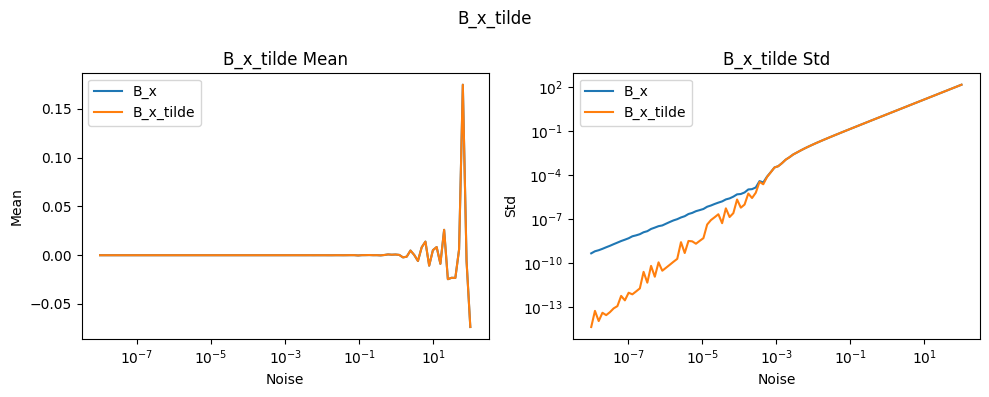

In [55]:
# Plot B_mean and B_std as a function of noise
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('B_x_tilde')
axs[0].plot(B_x_distribution['Noise'], B_x_distribution['B_Mean'])
axs[0].plot(B_x_distribution['Noise'], B_x_distribution['B_tilde_Mean'])
axs[0].set_title('B_x_tilde Mean')
axs[0].set_xscale('log')
# axs[0].set_yscale('log')
axs[0].set_xlabel('Noise')
axs[0].set_ylabel('Mean')
axs[0].legend(['B_x', 'B_x_tilde'])

axs[1].plot(B_x_distribution['Noise'], B_x_distribution['B_Std'])
axs[1].plot(B_x_distribution['Noise'], B_x_distribution['B_tilde_Std'])
axs[1].set_title('B_x_tilde Std')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('Noise')
axs[1].set_ylabel('Std')
axs[1].legend(['B_x', 'B_x_tilde'])

plt.tight_layout()
plt.show()

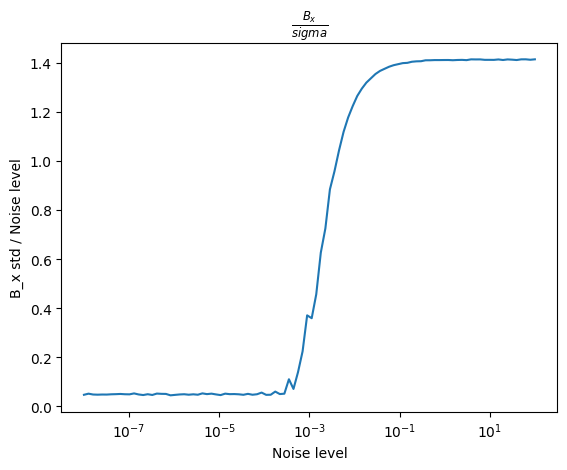

In [47]:
plt.plot(B_x_distribution['Noise'], B_x_distribution['B_Std'] / B_x_distribution['Noise'])
plt.xlabel('Noise level')
plt.xscale('log')
plt.ylabel('B_x std / Noise level')
plt.title(r"$\frac{B_x}{sigma}$")
plt.show()

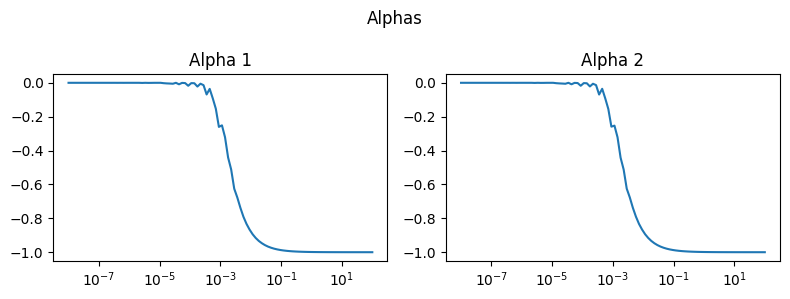

In [48]:
# Plot the alphas
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
fig.suptitle('Alphas')
axs[0].plot(B_x_distribution['Noise'], B_x_distribution['Alpha1_Mean'])
axs[0].set_title('Alpha 1')
axs[0].set_xscale('log')
axs[1].plot(B_x_distribution['Noise'], B_x_distribution['Alpha2_Mean'])
axs[1].set_title('Alpha 2')
axs[1].set_xscale('log')
plt.tight_layout()
plt.show()

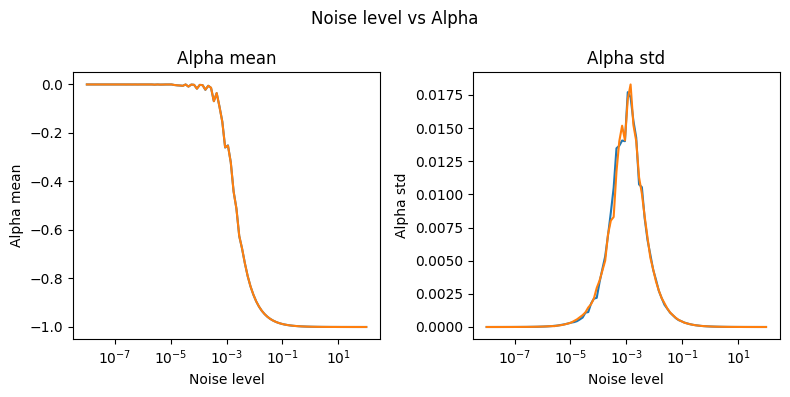

In [49]:
# plot alpha as a function of noise
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Noise level vs Alpha')
axs[0].plot(B_x_distribution['Noise'], B_x_distribution['Alpha1_Mean'], label='Alpha 1')
axs[0].plot(B_x_distribution['Noise'], B_x_distribution['Alpha2_Mean'], label='Alpha 2')
axs[0].set_xlabel('Noise level')
axs[0].set_xscale('log')
axs[0].set_ylabel('Alpha mean')
axs[0].set_title('Alpha mean')
axs[1].plot(B_x_distribution['Noise'], B_x_distribution['Alpha1_Std'], label='Alpha 1')
axs[1].plot(B_x_distribution['Noise'], B_x_distribution['Alpha2_Std'], label='Alpha 2')
axs[1].set_xlabel('Noise level')
axs[1].set_xscale('log')
axs[1].set_ylabel('Alpha std')
axs[1].set_title('Alpha std')

plt.tight_layout()
plt.show()

### Check if $B_x$ stays in the neighborhood of zero for all images and classes

In [67]:
num_exp = 10
results_B_x = pd.DataFrame(columns=[
    'Category', 'Image_Pair', 'Alpha_1_Mean', 'Alpha_1_Std', 'Alpha_2_Mean', 'Alpha_2_Std', 'B_x_Mean', 'B_x_Std'])


for category in category_names:
    print(f'Category: {category}')
    for noise in noise_values:
        for pair in list(itertools.combinations(image_numbers, 2)):
            alpha_1s = np.zeros(num_exp)
            alpha_2s = np.zeros(num_exp)
            B_xs = np.zeros((num_exp, resolution, resolution))  # Store B_x for each experiment
            image1 = Image(resolution, category_names[0], pair[0], full_path)
            image2 = Image(resolution, category_names[0], pair[1], full_path)

            for i in range(num_exp):
                results = Image.process_images(image1, image2, noise)
                alpha_1 = (1 / image1.image_post_noised.sum()) - 1
                alpha_2 = (1 / image2.image_post_noised.sum()) - 1
                B_x = image1.image_post_noised * alpha_1 - image2.image_post_noised * alpha_2
                alpha_1s[i] = alpha_1
                alpha_2s[i] = alpha_2
                B_xs[i, :, :] = B_x  # Store each B_x result

            # Calculate the means and standard deviations
            alpha_1_mean, alpha_1_std = alpha_1s.mean(), alpha_1s.std()
            alpha_2_mean, alpha_2_std = alpha_2s.mean(), alpha_2s.std()
            B_x_mean, B_x_std = B_xs.mean(axis=0), B_xs.std(axis=0)

            # Flatten B_x_mean and B_x_std for storage in DataFrame
            B_x_mean_flat = B_x_mean.flatten()
            B_x_std_flat = B_x_std.flatten()

            # Store results in the DataFrame
            results_B_x = results_B_x._append({
                'Category': category,
                'Noise': noise,
                'Image_Pair': pair,
                'Alpha_1_Mean': alpha_1_mean,
                'Alpha_1_Std': alpha_1_std,
                'Alpha_2_Mean': alpha_2_mean,
                'Alpha_2_Std': alpha_2_std,
                'B_x_Mean': B_x_mean_flat.mean(),  # Storing the overall mean of the matrix
                'B_x_Std': B_x_std_flat.mean()    # Storing the overall mean of the std of the matrix
            }, ignore_index=True)

Category: CauchyDensity


C:\Users\eriki\AppData\Local\Temp\ipykernel_15720\1535454990.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_B_x = results_B_x._append({


Category: ClassicImages
Category: GRFmoderate
Category: GRFrough
Category: GRFsmooth
Category: LogGRF
Category: LogitGRF
Category: MicroscopyImages
Category: Shapes
Category: WhiteNoise


In [68]:
# Save the results to a csv file
results_B_x.to_csv('results_B_x.csv', index=False)

In [72]:
results_B_x.head()

,Alpha_1_Mean,Alpha_1_Std,Alpha_2_Mean,Alpha_2_Std,B_x_Mean,B_x_Std,Noise
0,-0.000002,1.533282e-07,-0.000002,2.723104e-07,2.932975e-10,3.736957e-10,1.000000e-08
1,-0.000002,3.332078e-07,-0.000002,3.268719e-07,7.079014e-11,4.583789e-10,1.000000e-08
2,-0.000001,2.017306e-07,-0.000002,2.757963e-07,2.191872e-10,4.028244e-10,1.000000e-08
3,-0.000002,1.429360e-07,-0.000001,3.221716e-07,-1.564080e-10,4.364449e-10,1.000000e-08
4,-0.000002,1.851331e-07,-0.000002,1.943361e-07,-7.430545e-11,3.598206e-10,1.000000e-08


In [75]:
# results_B_x = results_B_x.drop(['Category', 'Image_Pair'], axis=1)

In [84]:
results_B_x['log_Noise'] = np.log10(results_B_x['Noise'])

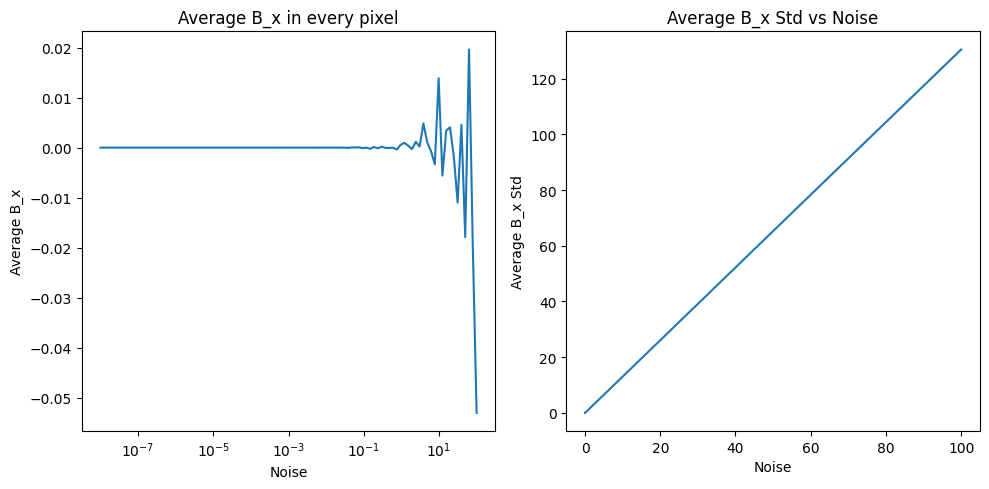

In [100]:
grouped_results = results_B_x.groupby('Noise').mean().reset_index()

# Plot B_x_mean vs Noise
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(grouped_results['Noise'], grouped_results['B_x_Mean'])
plt.xscale('log')
plt.xlabel('Noise')
plt.ylabel('Average B_x')
plt.title('Average B_x in every pixel')

# Plot B_x_std vs Noise
plt.subplot(1, 2, 2)
plt.plot(grouped_results['Noise'], grouped_results['B_x_Std'])
# plt.xscale('log')
plt.xlabel('Noise')
plt.ylabel('Average B_x Std')
plt.title('Average B_x Std vs Noise')

plt.tight_layout()
plt.show()

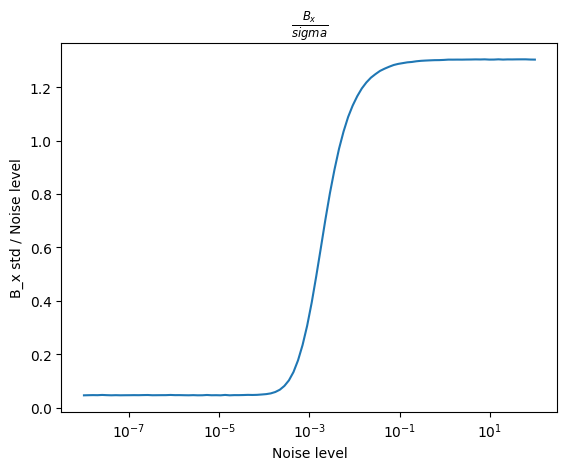

In [98]:
plt.plot(grouped_results['Noise'], grouped_results['B_x_Std'] / grouped_results['Noise'])
plt.xlabel('Noise level')
plt.xscale('log')
plt.ylabel('B_x std / Noise level')
plt.title(r"$\frac{B_x}{sigma}$")
plt.show()

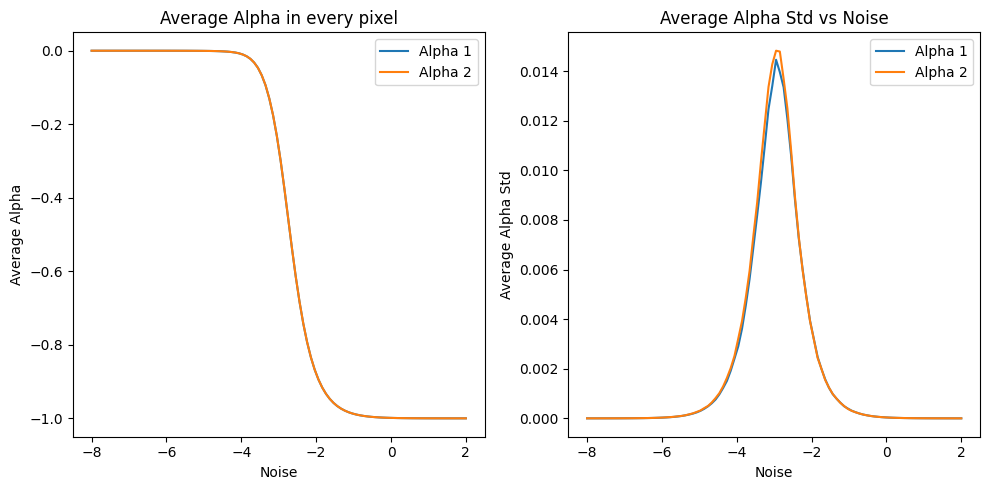

In [89]:
# Plot the alphas:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(grouped_results['log_Noise'], grouped_results['Alpha_1_Mean'], label='Alpha 1')
plt.plot(grouped_results['log_Noise'], grouped_results['Alpha_2_Mean'], label='Alpha 2')
# plt.xscale('log')
plt.xlabel('Noise')
plt.ylabel('Average Alpha')
plt.title('Average Alpha in every pixel')
plt.legend()

# Plot B_x_std vs Noise
plt.subplot(1, 2, 2)
plt.plot(grouped_results['log_Noise'], grouped_results['Alpha_1_Std'], label='Alpha 1')
plt.plot(grouped_results['log_Noise'], grouped_results['Alpha_2_Std'], label='Alpha 2')
# plt.xscale('log')
plt.xlabel('Noise')
plt.ylabel('Average Alpha Std')
plt.title('Average Alpha Std vs Noise')
plt.legend()

plt.tight_layout()
plt.show()

In [79]:
# Normality test for alpha_std:
stat, p_value = normaltest()
print(f'Alpha 1 normality test: {stat}, {p_value}')
stat, p_value = normaltest()
print(f'Alpha 2 normality test: {stat}, {p_value}')

Alpha 1 normality test: 42.36091057386917, 6.330603954169381e-10
Alpha 2 normality test: 42.0853995188741, 7.265602100789392e-10


In [90]:
from scipy.optimize import curve_fit

# Logistic function for Alpha Mean
def logistic(x, A, B, C):
    return A / (1 + np.exp(B * (x - C)))

# Gaussian function for Alpha Std
def gaussian(x, D, E, F):
    return D * np.exp(-((x - E) ** 2) / (2 * F ** 2))

#### Logistic:
*f($\alpha$) = $\frac{A}{1+e^{B * (\alpha - C)}}$*

#### Gaussian:
*f($\alpha$) = $D * e^{-\frac{(\alpha - E)^2}{2 * F^2}}$*

In [92]:
params_mean, params_covariance = curve_fit(logistic, grouped_results['log_Noise'], grouped_results['Alpha_1_Mean'], p0=[1, 1, 0])
params_std, params_cov_std = curve_fit(gaussian, grouped_results['log_Noise'], grouped_results['Alpha_1_Std'], p0=[1, 0, 1])

c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


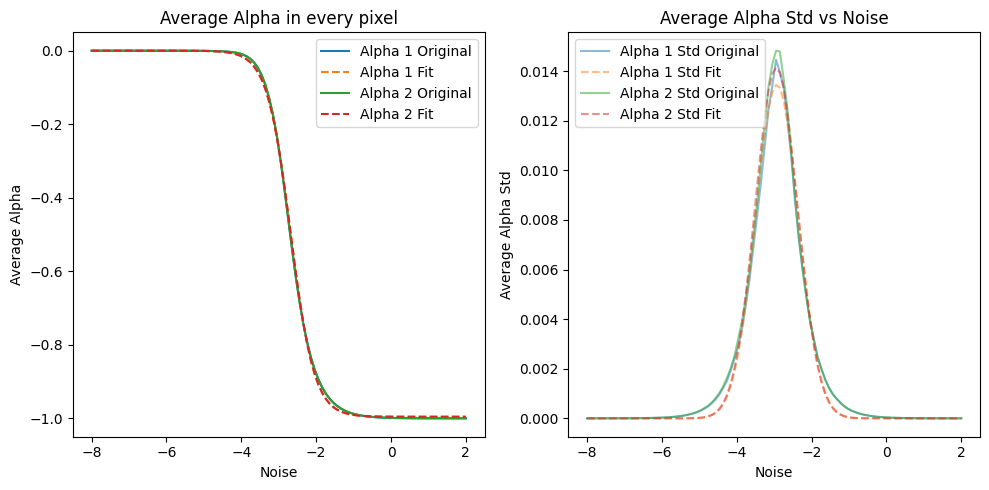

In [96]:
# Fit the models for Alpha 1 Mean
params_mean_1, _ = curve_fit(logistic, grouped_results['log_Noise'], grouped_results['Alpha_1_Mean'], p0=[1, 1, 0])
params_mean_2, _ = curve_fit(logistic, grouped_results['log_Noise'], grouped_results['Alpha_2_Mean'], p0=[1, 1, 0])

# Fit the models for Alpha 1 Std
params_std_1, _ = curve_fit(gaussian, grouped_results['log_Noise'], grouped_results['Alpha_1_Std'], p0=[0.01, 0, 1])
params_std_2, _ = curve_fit(gaussian, grouped_results['log_Noise'], grouped_results['Alpha_2_Std'], p0=[0.01, 0, 1])

# Generate fitted values
fitted_mean_1 = logistic(grouped_results['log_Noise'], *params_mean_1)
fitted_mean_2 = logistic(grouped_results['log_Noise'], *params_mean_2)
fitted_std_1 = gaussian(grouped_results['log_Noise'], *params_std_1)
fitted_std_2 = gaussian(grouped_results['log_Noise'], *params_std_2)

# Plot the alphas:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(grouped_results['log_Noise'], grouped_results['Alpha_1_Mean'], label='Alpha 1 Original')
plt.plot(grouped_results['log_Noise'], fitted_mean_1, label='Alpha 1 Fit', linestyle='--')
plt.plot(grouped_results['log_Noise'], grouped_results['Alpha_2_Mean'], label='Alpha 2 Original')
plt.plot(grouped_results['log_Noise'], fitted_mean_2, label='Alpha 2 Fit', linestyle='--')
plt.xlabel('Noise')
plt.ylabel('Average Alpha')
plt.title('Average Alpha in every pixel')
plt.legend()

# Plot Alpha Std vs Noise
plt.subplot(1, 2, 2)
plt.plot(grouped_results['log_Noise'], grouped_results['Alpha_1_Std'], label='Alpha 1 Std Original', alpha=0.5)
plt.plot(grouped_results['log_Noise'], fitted_std_1, label='Alpha 1 Std Fit', linestyle='--', alpha=0.5)
plt.plot(grouped_results['log_Noise'], grouped_results['Alpha_2_Std'], label='Alpha 2 Std Original', alpha=0.5)
plt.plot(grouped_results['log_Noise'], fitted_std_2, label='Alpha 2 Std Fit', linestyle='--', alpha=0.5)
plt.xlabel('Noise')
plt.ylabel('Average Alpha Std')
plt.title('Average Alpha Std vs Noise')
plt.legend()

plt.tight_layout()
plt.show()

In [95]:
print(f'Alpha 1: A={params_mean_1[0]}, B={params_mean_1[1]}, C={params_mean_1[2]}')
print(f'Alpha 2: A={params_mean_2[0]}, B={params_mean_2[1]}, C={params_mean_2[2]}')
print(f'Alpha 1 Std: D={params_std_1[0]}, E={params_std_1[1]}, F={params_std_1[2]}')
print(f'Alpha 2 Std: D={params_std_2[0]}, E={params_std_2[1]}, F={params_std_2[2]}')

Alpha 1: A=-0.9956268435940342, B=-3.1648048702050624, C=-2.679882678383225
Alpha 2: A=-0.9956318221390686, B=-3.1655799501481257, C=-2.6795730998309506
Alpha 1 Std: D=0.013457076533728221, E=-2.9256368971065125, F=-0.5707308797807371
Alpha 2 Std: D=0.014138090067490009, E=-2.942826308841845, F=-0.5661654239342165


### Looking into the total sum, $[\sum_{x\in G_N} e^{-i<x,k>} \cdot B_x] \times [\sum_{y\in G_N} e^{i<y,k>} \cdot B_y]$

In [123]:
num_exp = 1000
noise_values = np.logspace(start = -8, stop = 2, num = 100)
summands_lists = [] * len(noise_values)
summands_means = np.zeros(len(noise_values))

total_sum_df = pd.DataFrame(columns=['Noise', 'Abs_Sum'])

for noise in tqdm(noise_values):
    for i in range(num_exp):
        # Randomly select image indexes and category indexes
        image_indexes = np.random.randint(0, 10, 2)
        category_indexes = np.random.randint(0, 10, 2)
        
        # Create image instances
        image1 = Image(resolution, category_names[category_indexes[0]], image_numbers[image_indexes[0]], full_path)
        image2 = Image(resolution, category_names[category_indexes[1]], image_numbers[image_indexes[1]], full_path)
        
        # Process images
        results = Image.process_images(image1, image2, noise)
        alpha_1 = (1 / image1.image_post_noised.sum()) - 1
        alpha_2 = (1 / image2.image_post_noised.sum()) - 1

        sum_left = 0
        sum_right = 0
        k = np.random.randint(1, resolution + 1, size=2)
        
        # Calculate sum_left and sum_right
        for x in range(resolution):
            for y in range(resolution):
                B_x = image1.image_post_noised[x, y] * alpha_1 - image2.image_post_noised[x, y] * alpha_2
                location = np.array([x, y])
                exponent = np.exp(-1j * np.dot(location, k))
                sum_left += exponent * B_x
                exponent = np.exp(1j * np.dot(location, k))
                sum_right += exponent * B_x
        
        # Compute absolute sum
        abs_sum = abs(sum_left * sum_right)
        
        # Append results to DataFrame
        total_sum_df = total_sum_df._append({
            'Noise': noise,
            'Experiment': i + 1,
            'Abs_Sum': abs_sum
        }, ignore_index=True)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\eriki\AppData\Local\Temp\ipykernel_32984\3382223551.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total_sum_df = total_sum_df._append({
100%|██████████| 100/100 [15:59<00:00,  9.60s/it]


In [278]:
# Save the results to a csv file
total_sum_df.to_csv('csvs/total_sum_df254.csv', index=False)

In [124]:
total_sum_df.head()

,Noise,Abs_Sum,Experiment
0,1.000000e-08,5.710983e-18,1.0
1,1.000000e-08,1.639900e-16,2.0
2,1.000000e-08,2.656665e-18,3.0
3,1.000000e-08,1.739646e-19,4.0
4,1.000000e-08,2.950201e-15,5.0


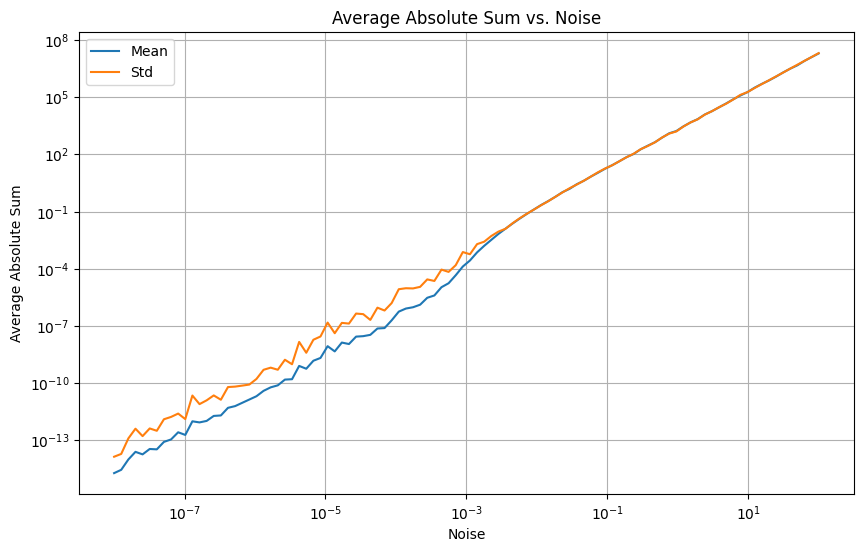

In [125]:
combined_results = total_sum_df.groupby('Noise')['Abs_Sum'].agg(['mean', 'std']).reset_index()

# Rename columns for clarity
combined_results.columns = ['Noise', 'Abs_Sum_Mean', 'Abs_Sum_Std']

# Plotting the average absolute sum against noise with error bars
plt.figure(figsize=(10, 6))
#plt.errorbar(combined_results['Noise'], combined_results['Abs_Sum_Mean'], yerr=combined_results['Abs_Sum_Std'], ecolor='r', capsize=5, label='Mean ± Std')
plt.plot(combined_results['Noise'], combined_results['Abs_Sum_Mean'], label='Mean')
plt.plot(combined_results['Noise'], combined_results['Abs_Sum_Std'], label='Std')
plt.xscale('log')  # Logarithmic scale for noise values
plt.yscale('log')  # Logarithmic scale for average absolute sum
plt.xlabel('Noise')
plt.ylabel('Average Absolute Sum')
plt.title('Average Absolute Sum vs. Noise')
plt.legend()
plt.grid(True)
plt.show()

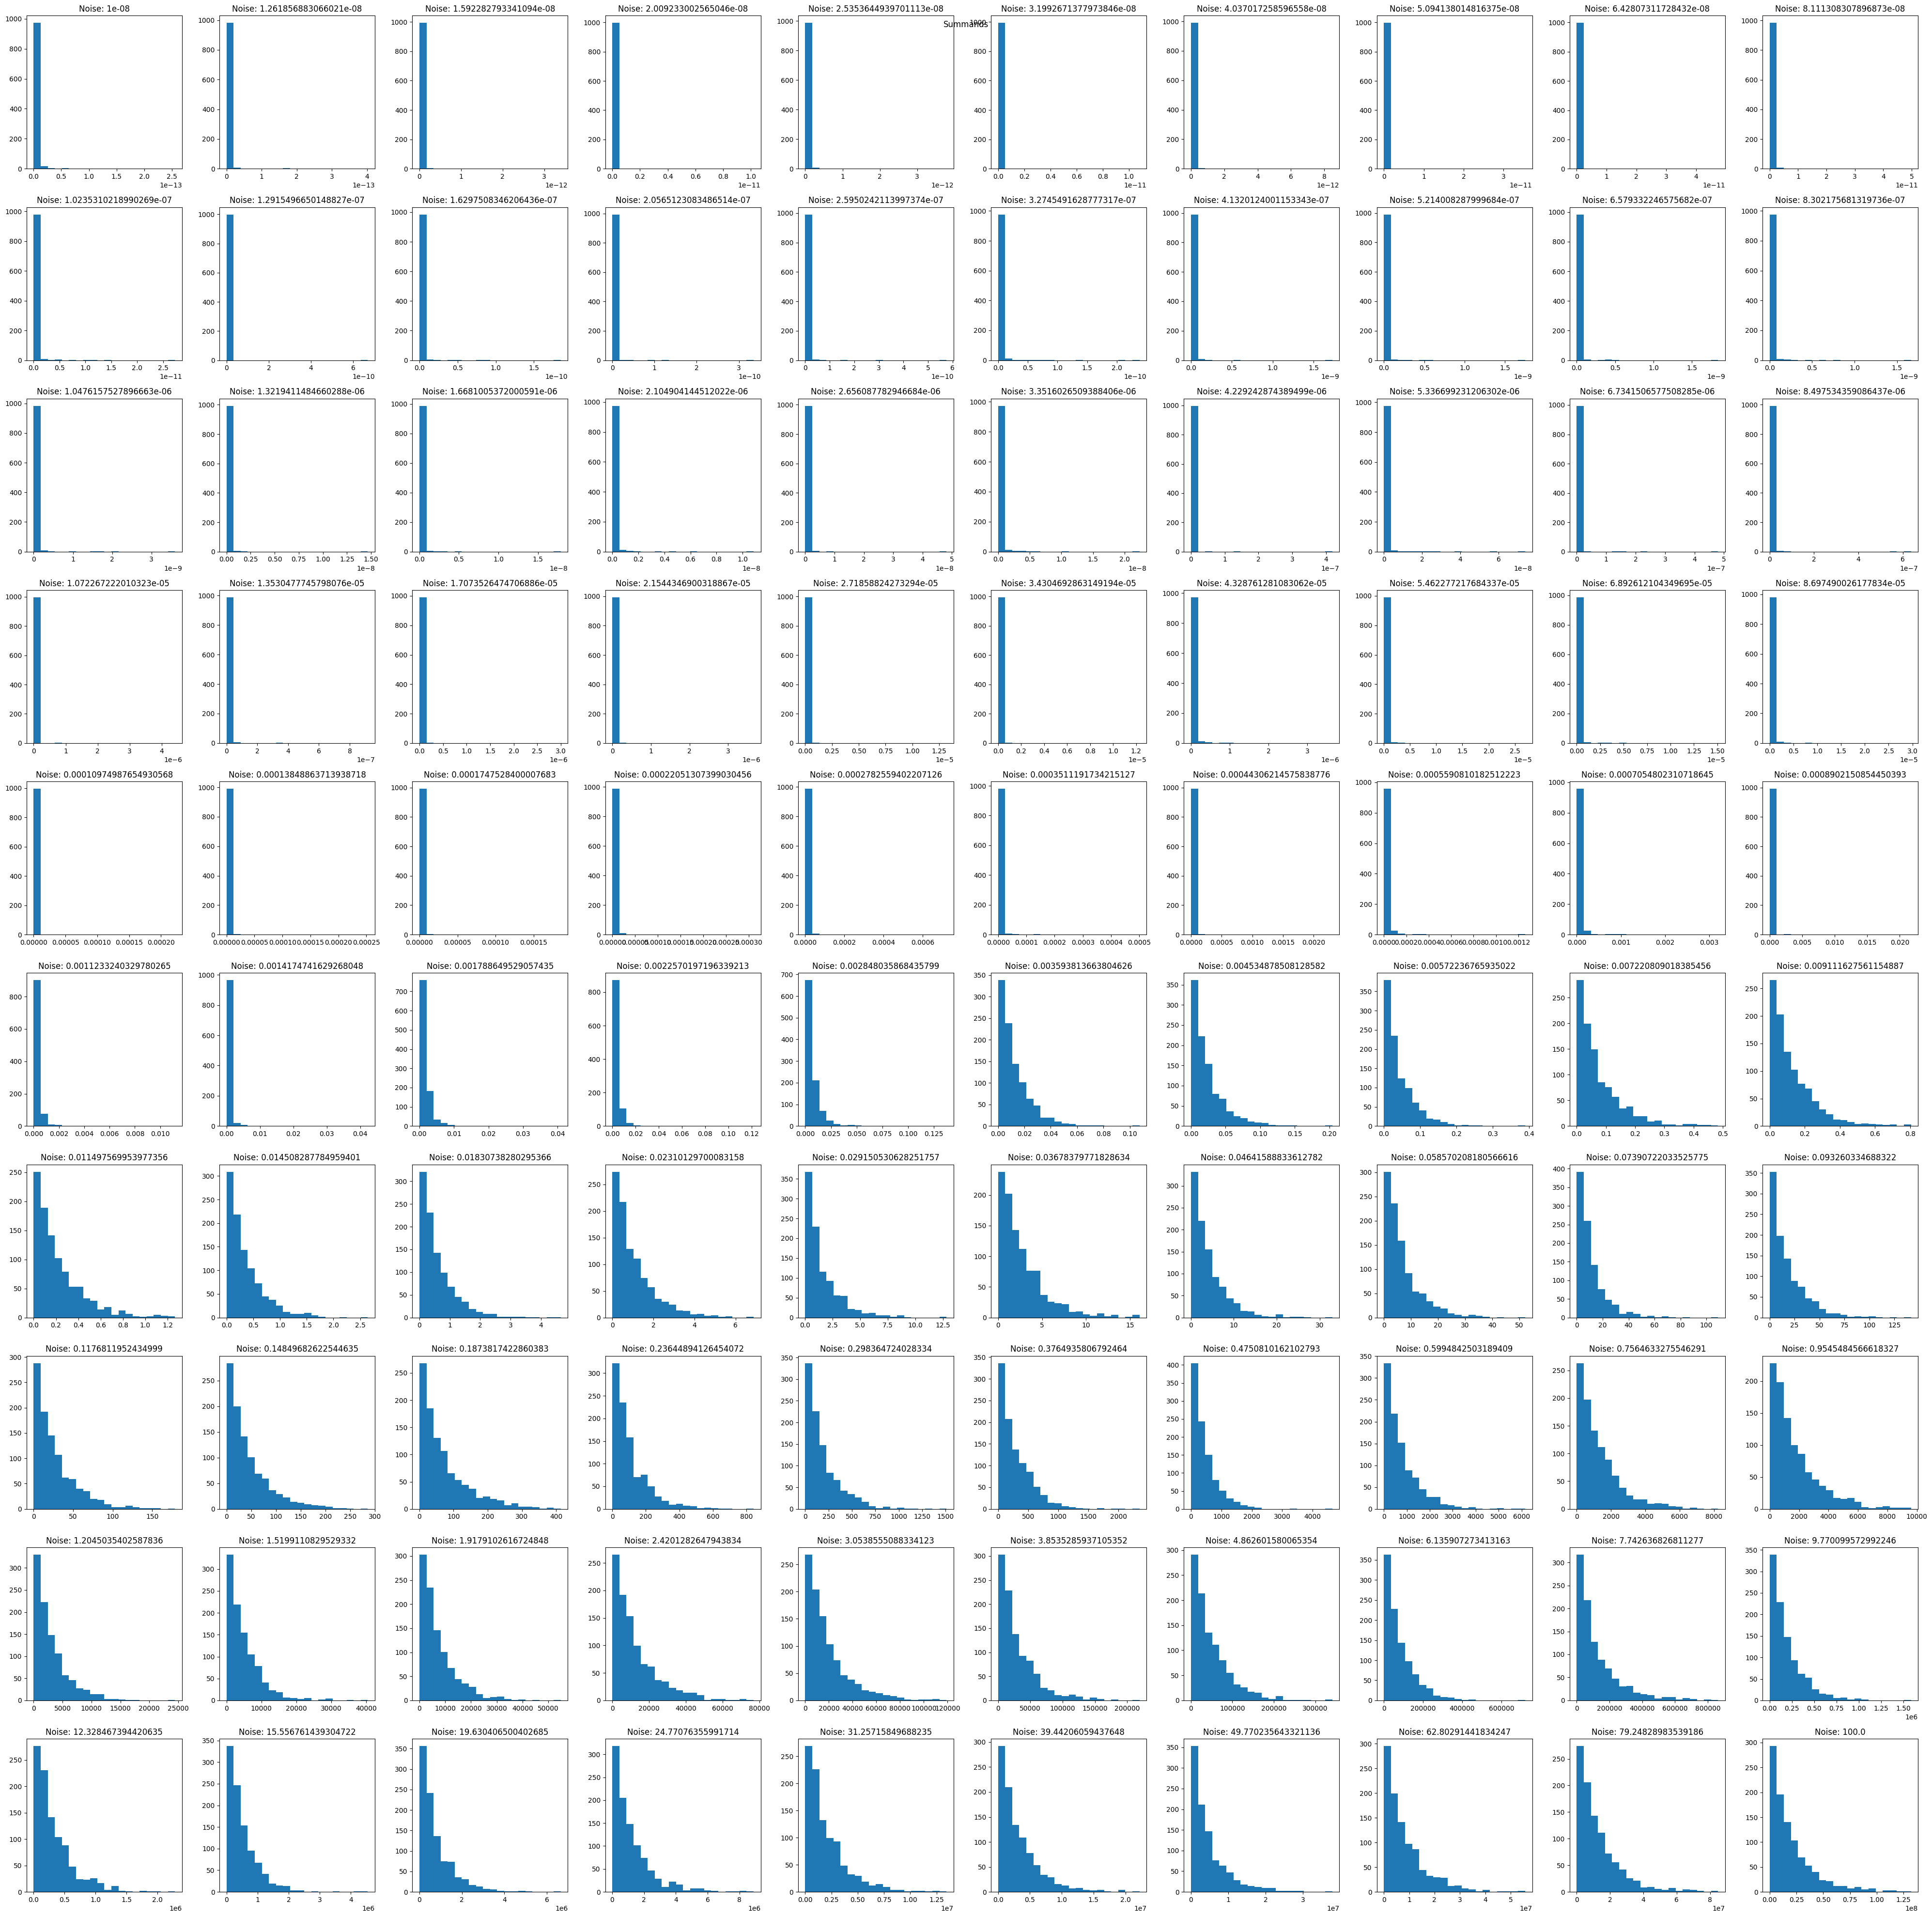

In [126]:
# plot a 10x10 grid of the summands
fig, axs = plt.subplots(10, 10, figsize=(40, 40))
fig.suptitle('Summands')
for i in range(10):
    for j in range(10):
        subset = total_sum_df[(total_sum_df['Noise'] == noise_values[i * 10 + j])]
        axs[i, j].hist(subset['Abs_Sum'], bins=20)
        axs[i, j].set_title(f'Noise: {noise_values[i * 10 + j]}')
plt.tight_layout()
plt.show()

### different classes, structured

In [127]:
num_exp = 100
noise_values = np.logspace(start = -8, stop = 2, num = 10)
# Initialize an empty DataFrame
results_df_categories = pd.DataFrame(columns=['Noise', 'Abs_Sum'])

for noise in tqdm(noise_values):
    for category in category_names:
        for pair in list(itertools.combinations(image_numbers, 2)):
            image1 = Image(resolution, category, pair[0], full_path)
            image2 = Image(resolution, category, pair[1], full_path)
            for i in range(num_exp):
                sum = 0
                sum_left = 0
                sum_right = 0
                results = Image.process_images(image1, image2, noise)
                alpha_1 = (1 / image1.image_post_noised.sum()) - 1
                alpha_2 = (1 / image2.image_post_noised.sum()) - 1
                k = np.random.randint(1, resolution + 1, size=2)
                # This is for the left summand in (44) - sum of exp{-i<x,k>} B_x
                for x in range(resolution):
                    for y in range(resolution):
                        B_x = image1.image_post_noised[x, y] * alpha_1 - image2.image_post_noised[x, y] * alpha_2
                        location = np.array([x, y])
                        exponent = np.exp(-1j * np.dot(location, k))
                        summand = exponent * B_x
                        sum_left += summand
                # This is for the right summand in (44) - sum of exp{i<x,k>} B_x
                for x in range(resolution):
                    for y in range(resolution):
                        B_x = image1.image_post_noised[x, y] * alpha_1 - image2.image_post_noised[x, y] * alpha_2
                        location = np.array([x, y])
                        exponent = np.exp(1j * np.dot(location, k))
                        summand = exponent * B_x
                        sum_right += summand
                sum = abs(sum_left * sum_right)
                result = {
                    'Noise': noise,
                    'Category': category,
                    'Image_Pair': pair,
                    'Experiment': i + 1,  # experiment number (1 indexed)
                    'Sum_Left': sum_left,
                    'Sum_Right': sum_right,
                    'Abs_Sum': sum
                }

                # Append the result to the DataFrame
                results_df_categories = results_df_categories._append(result, ignore_index=True)

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\eriki\AppData\Local\Temp\ipykernel_32984\3517266747.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df_categories = results_df_categories._append(result, ignore_index=True)
100%|██████████| 10/10 [1:33:12<00:00, 559.25s/it]


In [277]:
# Save the results to a csv file
results_df_categories.to_csv('csvs/results_df_categories_254.csv', index=False)

In [128]:
results_df_categories.head()

,Noise,Abs_Sum,Category,Image_Pair,Experiment,Sum_Left,Sum_Right
0,1.000000e-08,9.711785e-17,CauchyDensity,"(01, 02)",1.0,-6.842509e-09+7.092102e- 09j,-6.842509e-09-7.092102e- 09j
1,1.000000e-08,6.628654e-16,CauchyDensity,"(01, 02)",2.0,2.584178e-09+2.561616e- 08j,2.584178e-09-2.561616e- 08j
2,1.000000e-08,1.743861e-16,CauchyDensity,"(01, 02)",3.0,-1.010609e-08-8.500176e- 09j,-1.010609e-08+8.500176e- 09j
3,1.000000e-08,2.312531e-15,CauchyDensity,"(01, 02)",4.0,4.754479e-08+7.212759e- 09j,4.754479e-08-7.212759e- 09j
4,1.000000e-08,3.466302e-13,CauchyDensity,"(01, 02)",5.0,2.984585e-07+5.074966e- 07j,2.984585e-07-5.074966e- 07j


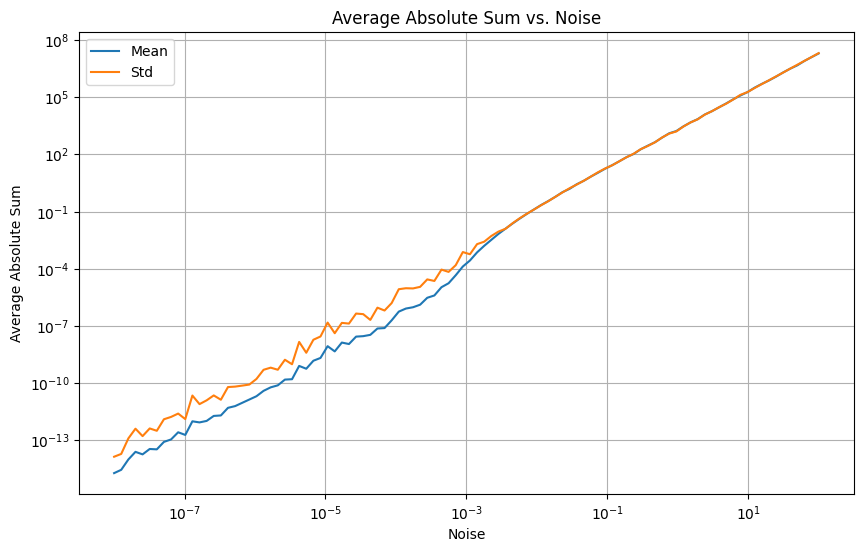

In [131]:
combined_results = total_sum_df.groupby('Noise')['Abs_Sum'].agg(['mean', 'std']).reset_index()

# Rename columns for clarity
combined_results.columns = ['Noise', 'Abs_Sum_Mean', 'Abs_Sum_Std']

# Plotting the average absolute sum against noise with error bars
plt.figure(figsize=(10, 6))
#plt.errorbar(combined_results['Noise'], combined_results['Abs_Sum_Mean'], yerr=combined_results['Abs_Sum_Std'], ecolor='r', capsize=5, label='Mean ± Std')
plt.plot(combined_results['Noise'], combined_results['Abs_Sum_Mean'], label='Mean')
plt.plot(combined_results['Noise'], combined_results['Abs_Sum_Std'], label='Std')
plt.xscale('log')  # Logarithmic scale for noise values
plt.yscale('log')  # Logarithmic scale for average absolute sum
plt.xlabel('Noise')
plt.ylabel('Average Absolute Sum')
plt.title('Average Absolute Sum vs. Noise')
plt.legend()
plt.grid(True)
plt.show()

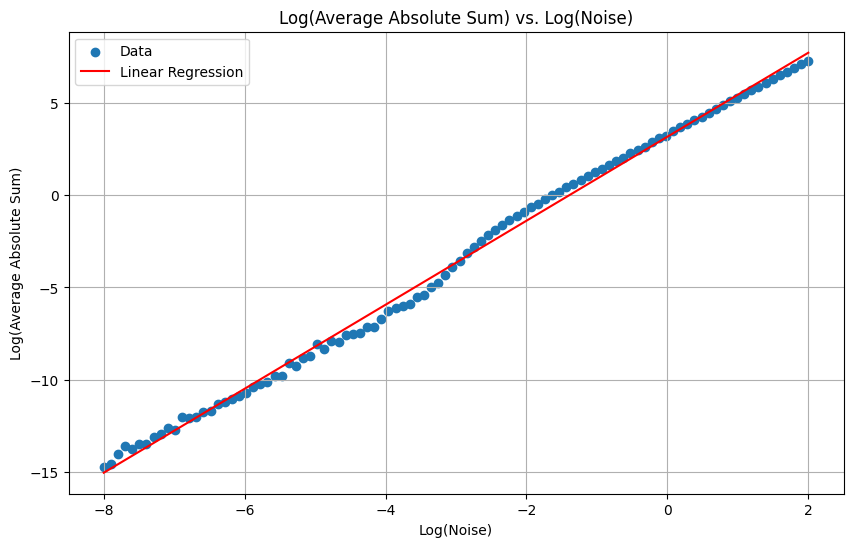

In [135]:
from sklearn.linear_model import LinearRegression

# Fit a linear regression model to the data
X = np.log10(combined_results['Noise']).values.reshape(-1, 1)
y = np.log10(combined_results['Abs_Sum_Mean'])

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(X, y)

# Get the model parameters
slope = model.coef_[0]
intercept = model.intercept_

# Plot the data and the linear regression model
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Data')
plt.plot(X, model.predict(X), color='red', label='Linear Regression')
plt.xlabel('Log(Noise)')
plt.ylabel('Log(Average Absolute Sum)')
plt.title('Log(Average Absolute Sum) vs. Log(Noise)')
plt.legend()
plt.grid(True)
plt.show()